Recreating co-teaching for improvement of robustness of image classification to noisy labels in Tensorflow 2. 

*Han, B., Yao, Q., Yu, X., Niu, G., Xu, M., Hu, W., ... & Sugiyama, M. (2018). Co-teaching: Robust training of deep neural networks with extremely noisy labels. Advances in neural information processing systems, 31.*

Original PyTorch implementation from https://github.com/bhanML/Co-teaching

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import Dropout, Dense, Flatten, Input
from tensorflow.keras.losses import Loss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import random
import time
import pickle
import os

Making saving logs faster using pickle

In [2]:
def write_pickle(log_dict, pickle_name):
    pickle_name += '.pickle'
    pickle_path = os.path.join('./', pickle_name)
    with open(pickle_path, 'wb') as pickle_out:
        pickle.dump(log_dict, pickle_out)
    print(f"Log saved to {pickle_path}.")
    
def read_pickle(pickle_name):
    pickle_name += '.pickle'    
    pickle_path = os.path.join('./', pickle_name)    
    log_dict = {}
    if os.path.exists(pickle_path):
        with open(pickle_path, 'rb') as pickle_in:
            log_dict = pickle.load(pickle_in)
        print(f"Log loaded from {pickle_path}")
    else:
        print(f"File not found : {pickle_path}")
    return log_dict 


Loading MNIST dataset and limiting size to 2000 for fast execution

In [3]:
data_size = 2000
lr = 0.001
batch_size = 128
val_frac = 0.2
num_epochs = 50
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train[:data_size].astype(np.float32)/255.0
y_train = y_train[:data_size]
x_test = x_test.astype(np.float32)/255.0
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

Preparing datasets and normalizing data

In [5]:
def get_mean_std(images):
    mean = ()
    std = ()
    for i in range(images.shape[-1]):
        mean += (np.mean(images[:, :, :, i]),)
        std += (np.std(images[:, :, :, i]),)
    return mean, std

def normalize(images, mean, std):
    for i in range(images.shape[-1]):
        images[:, :, :, i] = (images[:, :, :, i] - mean[i])/std[i]
    return images

mean, std = get_mean_std(x_train)
x_train = normalize(x_train, mean, std)
x_test = normalize(x_test, mean, std)

In [6]:
def convert_to_one_hot(image, label, indices):
    label = tf.one_hot(label, 10)
    return image, tf.cast(label, tf.float32), indices

In [7]:
def train_val_split(x_train, y_train, val_frac=0.2):
    perm_idx = np.random.permutation(x_train.shape[0])
    val_idx = perm_idx[:int(val_frac*x_train.shape[0])]
    train_idx = perm_idx[int(val_frac*x_train.shape[0]):]
    x_val, y_val = x_train[val_idx], y_train[val_idx]
    x_train, y_train = x_train[train_idx], y_train[train_idx]
    return (x_train, y_train), (x_val, y_val)

In [8]:
# (x_train_base, y_train_base), (x_val, y_val) = train_val_split(x_train, y_train, 0.2)
x_train_base, y_train_base = x_train, y_train
train_indices = np.arange(len(y_train_base))
test_indices = np.arange(len(y_test))
train_ds = (tf.data.Dataset.from_tensor_slices((x_train_base, y_train_base, train_indices))
                            .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
                            .batch(batch_size))
# val_ds = (tf.data.Dataset.from_tensor_slices((x_val, y_val))
#                             .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
#                             .batch(batch_size))
test_ds = (tf.data.Dataset.from_tensor_slices((x_test, y_test, test_indices))
                            .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
                            .batch(batch_size))

Plotting some images

In [9]:
def plot_images(ds):
    plt.figure(figsize=(12, 12))
    for images, targets, _ in ds.take(1):
        for i in range(9):
            plt.subplot(3, 3, i+1)
            plt.imshow(images[i], cmap='gray')
            plt.title(np.argmax(targets[i].numpy()))


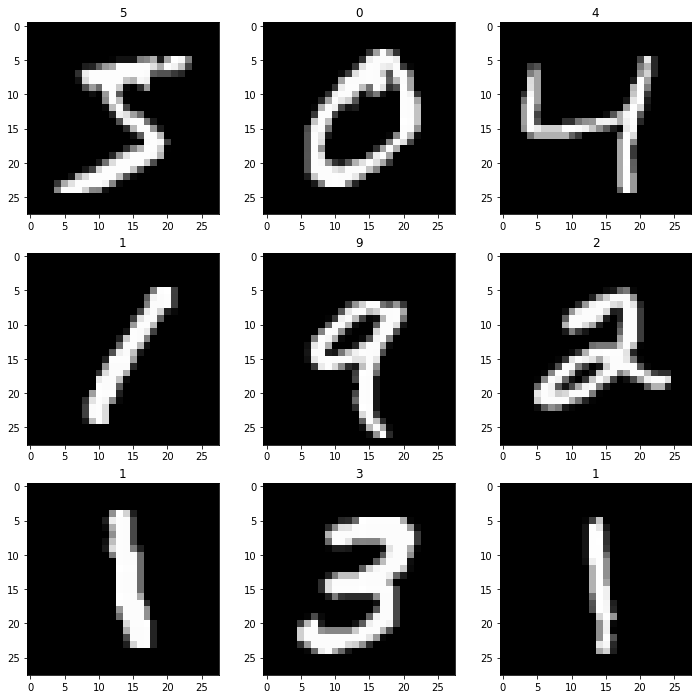

In [10]:
plot_images(train_ds)

Defining model and compile parameters

In [11]:
class base_model(Model):
    def __init__(self, num_classes=10):
        super(base_model, self).__init__()        
        self.conv1 = Conv2D(10, kernel_size = 5, padding='same')
        self.pool1 = MaxPooling2D(pool_size = 2)
        self.conv2 = Conv2D(20, kernel_size = 3, padding = 'same')     
        self.drop1 = Dropout(0.5)
        self.pool2 = MaxPooling2D(pool_size = 2)
        self.flatten = Flatten()
        self.dense1 = Dense(30, activation = 'relu')
        self.drop2 = Dropout(0.5)
        self.dense2 = Dense(num_classes)

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.pool1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.drop1(x)
        x = self.pool2(x)
        x = tf.nn.relu(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.drop2(x)
        return self.dense2(x)    
        

Building training, evaluation and testing loops

In [12]:
# def fit_gmm(losses):    
#     losses = losses.numpy()
#     losses = (losses-losses.min())/(losses.max()-losses.min())
#     input_loss = np.reshape(losses, [-1, 1])

#     gmm = GaussianMixture(n_components=2, max_iter=50, tol=1e-2, reg_covar=5e-4)
#     gmm.fit(input_loss)
#     prob = gmm.predict_proba(input_loss)
#     prob = prob[:, gmm.means_.argmin()]
#     return prob

class train_step_func():    
    def __init__(self, model, optimizer, loss_f):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_f
    
    @tf.function
    def __call__(self, x_batch, y_batch):
        with tf.GradientTape() as tape:
            y_pred = self.model(x_batch, training=True)  
            loss = self.loss_fn(y_batch, y_pred)     
        gradients = tape.gradient(loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))        
        y_batch_single = tf.math.argmax(y_batch, axis = 1)
        y_pred_single = tf.math.argmax(y_pred, axis = 1)
        correct = tf.math.reduce_sum(tf.where(y_pred_single == y_batch_single, 1.0, 0.0))
        return loss, correct

class val_step_func():
    def __init__(self, model, loss_f):
        self.model = model
        self.loss_fn = loss_f
   
    @tf.function
    def __call__(self, x_batch, y_batch):
        y_pred = self.model(x_batch)
        loss = self.loss_fn(y_batch, y_pred)
        y_pred_single = tf.math.argmax(y_pred, axis=1)
        y_batch_single = tf.math.argmax(y_batch, axis = 1)  
        correct = tf.math.reduce_sum(tf.where(y_pred_single == y_batch_single, 1.0, 0.0)) 
        return loss, correct

class test_step_func():
    def __init__(self, model):
        self.model = model
    
    @tf.function
    def __call__(self, x_batch, y_batch):    
        y_pred_single = tf.math.argmax(self.model(x_batch, training=False), axis=1)
        y_batch_single = tf.math.argmax(y_batch, axis = 1)
        correct = tf.math.reduce_sum(tf.where(y_pred_single == y_batch_single, 1.0, 0.0))
        return correct

def train_test_model(   
                        model,
                        optimizer,
                        train_ds,
                        val_ds,
                        test_ds,
                        loss_func,
                        loss_func_2,
                        num_epochs=1,
                        log_name='log'
                    ):
    logs = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[], 'val_losses':[]}
    num_classes = 10
    len_train_ds = len(list(train_ds.unbatch()))
    len_val_ds = len(list(val_ds.unbatch()))
    len_test_ds = len(list(test_ds.unbatch()))

    for epoch in range(num_epochs):          
        # training
        train_loss = tf.zeros(1)
        train_correct = tf.zeros(1)
        train_step = train_step_func(model, optimizer, loss_func) 
        for batch_id, (x_batch, y_batch, _) in enumerate(train_ds):  
            loss, correct = train_step(x_batch, y_batch)
            train_loss += loss*len(y_batch)
            train_correct += correct
        train_loss /= len_train_ds
        train_acc = train_correct/len_train_ds

        # filter losses
        # losses = tf.Variable(tf.zeros(len_val_ds))
        # val_step = val_step_func(model, loss_func_2)
        # for idx, (x_batch, y_batch, _) in enumerate(val_ds):
        #     loss, _ = val_step(x_batch, y_batch)
        #     for b in tf.range(x_batch.shape[0]):
        #         i = batch_size*idx+b
        #         losses[i].assign(tf.cast(loss[b], tf.float32))
        
        # fit loss to Gaussian mixture model
        # prob = fit_gmm(losses)  

        # validation
        val_correct = tf.zeros(1)
        val_loss = tf.zeros(1)
        val_step = val_step_func(model, loss_func_2)
        for idx, (x_batch, y_batch, _) in enumerate(test_ds):
            loss, correct = val_step(x_batch, y_batch)
            val_loss += tf.math.reduce_sum(loss)
            val_correct += correct
        val_loss /= float(len_test_ds)
        val_acc = val_correct/len_test_ds      

        logs['train_loss'].append(train_loss[0].numpy())
        logs['train_acc'].append(train_acc[0].numpy())
        logs['val_loss'].append(val_loss[0].numpy())
        logs['val_acc'].append(val_acc[0].numpy())
        # logs['val_losses'].append(losses.numpy())

        print(f'Epoch [{epoch+1}/{num_epochs}],\ttrain loss: {train_loss[0].numpy():.4f},\ttrain acc: {train_acc[0].numpy()*100:.2f} %,\tvalidation loss: {val_loss[0].numpy():.4f},\tvalidation accuracy: {val_acc[0].numpy()*100:.2f} %')

    # testing 
    test_correct = tf.zeros(1)
    test_step = test_step_func(model)
    for x_batch, y_batch, _ in test_ds:
        correct = test_step(x_batch, y_batch)
        test_correct += correct
    test_acc = test_correct/len_test_ds
    print(f"Test accuracy : {test_acc[0].numpy()*100:.2f} %")

    write_pickle(logs, log_name)    
    return logs
    

Setting model optimizer, loss and accuracy metric, compiling and training model

In [13]:
logs_baseline = read_pickle('logs_baseline')
if not bool(logs_baseline):
    tf.keras.backend.clear_session()
    start_time = time.time()
    tf.random.set_seed(123)
    model = base_model(10)
    loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_func_2 = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
    optimizer = tf.keras.optimizers.Adam(lr)
    logs_baseline = train_test_model(
                                    model,
                                    optimizer,
                                    train_ds, 
                                    train_ds, 
                                    test_ds, 
                                    loss_func, 
                                    loss_func_2,  
                                    num_epochs,
                                    log_name='logs_baseline')
    print(f"Training time : {(time.time() - start_time)/60:.2f} min.")

File not found : ./logs_baseline.pickle
Epoch [1/50],	train loss: 2.2122,	train acc: 18.80 %,	validation loss: 1.9816,	validation accuracy: 53.80 %
Epoch [2/50],	train loss: 1.7497,	train acc: 38.75 %,	validation loss: 1.5629,	validation accuracy: 65.49 %
Epoch [3/50],	train loss: 1.3839,	train acc: 51.45 %,	validation loss: 1.2194,	validation accuracy: 74.42 %
Epoch [4/50],	train loss: 1.1232,	train acc: 60.55 %,	validation loss: 0.9814,	validation accuracy: 80.55 %
Epoch [5/50],	train loss: 0.9414,	train acc: 67.45 %,	validation loss: 0.8205,	validation accuracy: 83.27 %
Epoch [6/50],	train loss: 0.8133,	train acc: 71.95 %,	validation loss: 0.7097,	validation accuracy: 85.17 %
Epoch [7/50],	train loss: 0.7047,	train acc: 74.85 %,	validation loss: 0.6171,	validation accuracy: 86.28 %
Epoch [8/50],	train loss: 0.6203,	train acc: 78.60 %,	validation loss: 0.5481,	validation accuracy: 87.06 %
Epoch [9/50],	train loss: 0.5532,	train acc: 80.75 %,	validation loss: 0.4915,	validation accura

Text(0, 0.5, 'Loss')

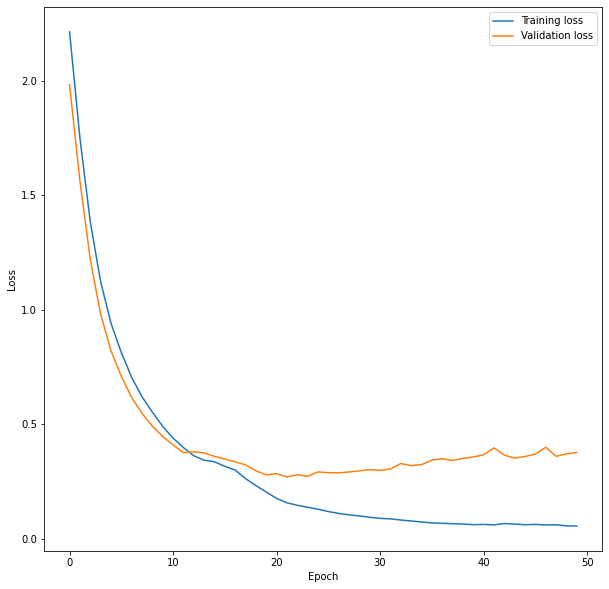

In [14]:
plt.figure(figsize=(10, 10))
plt.plot(range(num_epochs), logs_baseline['train_loss'], label = 'Training loss')
plt.plot(range(num_epochs), logs_baseline['val_loss'], label = 'Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

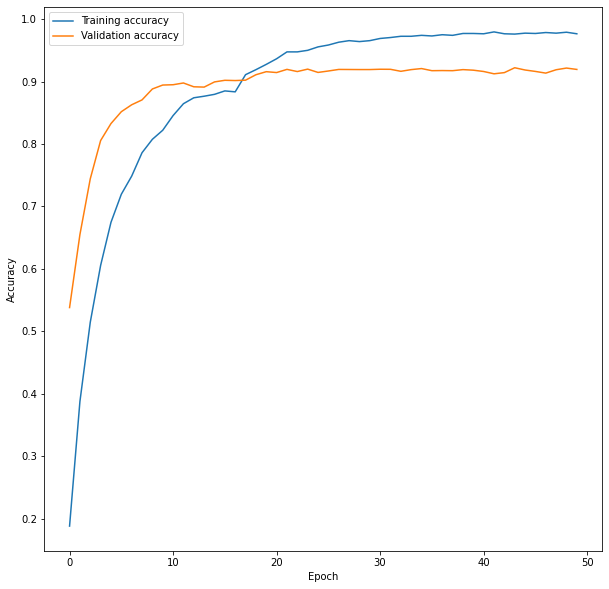

In [15]:
plt.figure(figsize=(10, 10))
plt.plot(range(num_epochs), logs_baseline['train_acc'], label = 'Training accuracy')
plt.plot(range(num_epochs), logs_baseline['val_acc'], label = 'Validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

### Generate Noisy MNIST

In [16]:
# clean ground truth labels
gt_labels = y_train_base

In [17]:
# generate noise

# class transition for asymmetric noise
transition = {0:0,2:0,4:7,7:7,1:1,9:1,3:5,5:3,6:6,8:8} 

def generate_noise(nr, gt_labels, noise_mode='sym'):
  noisy_labels = []
  idx = list(range(len(gt_labels)))
  random.shuffle(idx)
  num_noise = int(nr*len(gt_labels))            
  noise_idx = idx[:num_noise]
  for i in range(len(gt_labels)):
      if i in noise_idx:
        if noise_mode=='sym':
          noisylabel = random.randint(0,9)  
          noisy_labels.append(noisylabel)
        elif noise_mode=='asym':   
          noisylabel = transition[gt_labels[i].item()]
          noisy_labels.append(noisylabel)                    
      else:    
        noisy_labels.append(gt_labels[i])  
  return np.array(noisy_labels)

In [18]:
#generate noisy_benchmark
label_noise={}
label_noise['50_sym']=generate_noise(0.5, gt_labels, 'sym')
label_noise['70_sym']=generate_noise(0.7, gt_labels, 'sym')
label_noise['40_asym']=generate_noise(0.4, gt_labels, 'asym')

### Baseline on 50% symmetric noise rate

In [19]:
train_ds_noisy = (tf.data.Dataset.from_tensor_slices((x_train_base, label_noise['50_sym'], train_indices))
                                .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
                                .batch(batch_size))

In [20]:
log_name = 'logs_nb_50_sym'
logs_nb_50_sym = read_pickle(log_name)
if not bool(logs_nb_50_sym):
    tf.keras.backend.clear_session()
    start_time = time.time()
    tf.random.set_seed(123)
    model = base_model(10)
    loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_func_2 = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
    optimizer = tf.keras.optimizers.Adam(lr)
    logs_nb_50_sym = train_test_model(
                                    model,
                                    optimizer,
                                    train_ds_noisy, 
                                    test_ds, 
                                    test_ds, 
                                    loss_func, 
                                    loss_func_2,  
                                    num_epochs,
                                    log_name)
    print(f"Training time : {(time.time() - start_time)/60:.2f} min.")

File not found : ./logs_nb_50_sym.pickle
Epoch [1/50],	train loss: 2.3366,	train acc: 12.35 %,	validation loss: 2.2413,	validation accuracy: 38.41 %
Epoch [2/50],	train loss: 2.2241,	train acc: 18.50 %,	validation loss: 2.0899,	validation accuracy: 51.27 %
Epoch [3/50],	train loss: 2.1349,	train acc: 23.75 %,	validation loss: 1.9643,	validation accuracy: 61.69 %
Epoch [4/50],	train loss: 2.0498,	train acc: 28.85 %,	validation loss: 1.8346,	validation accuracy: 68.64 %
Epoch [5/50],	train loss: 1.9666,	train acc: 33.00 %,	validation loss: 1.7506,	validation accuracy: 73.08 %
Epoch [6/50],	train loss: 1.8961,	train acc: 36.15 %,	validation loss: 1.6914,	validation accuracy: 75.92 %
Epoch [7/50],	train loss: 1.8269,	train acc: 38.90 %,	validation loss: 1.6244,	validation accuracy: 77.92 %
Epoch [8/50],	train loss: 1.7561,	train acc: 40.70 %,	validation loss: 1.5808,	validation accuracy: 79.55 %
Epoch [9/50],	train loss: 1.6942,	train acc: 42.70 %,	validation loss: 1.5455,	validation accur

### Co-teaching

In [21]:
class train_step_co_teach_func():    
    def __init__(
        self, 
        model1,
        model2, 
        optimizer1,
        optimizer2, 
        loss_f, 
        loss_f_2):

        self.model1 = model1
        self.optimizer1 = optimizer1
        self.model2 = model2
        self.optimizer2 = optimizer2
        self.loss_fn = loss_f
        self.loss_fn_2 = loss_f_2
    
    @tf.function
    def __call__(self, x_batch, y_batch, num_remember):
        with tf.GradientTape(persistent=True) as tape:
            y_pred1 = self.model1(x_batch, training=True)  
            loss1 = self.loss_fn_2(y_batch, y_pred1)   
            ind_1_sorted = tf.argsort(loss1)

            y_pred2 = self.model2(x_batch, training=True)  
            loss2 = self.loss_fn_2(y_batch, y_pred2)
            ind_2_sorted = tf.argsort(loss2)

            ind_1_update = ind_1_sorted[:num_remember]
            ind_2_update = ind_2_sorted[:num_remember]

            #exchange
            loss_1_update = self.loss_fn(
                        tf.gather(y_batch, indices=ind_2_update),
                        tf.gather(y_pred1, indices=ind_2_update))
            loss_2_update = self.loss_fn(
                        tf.gather(y_batch, indices=ind_1_update),
                        tf.gather(y_pred2, indices=ind_1_update))

        gradients1 = tape.gradient(loss_1_update, self.model1.trainable_weights)   
        gradients2 = tape.gradient(loss_2_update, self.model2.trainable_weights) 
        self.optimizer1.apply_gradients(zip(gradients1, self.model1.trainable_weights)) 
        self.optimizer2.apply_gradients(zip(gradients2, self.model2.trainable_weights))

        # accuracy  
        y_batch_single = tf.math.argmax(y_batch, axis = 1)
        y_pred_single1 = tf.math.argmax(y_pred1, axis = 1)
        y_pred_single2 = tf.math.argmax(y_pred2, axis = 1)
        correct1 = tf.math.reduce_sum(tf.where(y_pred_single1 == y_batch_single, 1.0, 0.0))
        correct2 = tf.math.reduce_sum(tf.where(y_pred_single2 == y_batch_single, 1.0, 0.0))
        return loss_1_update, loss_2_update, correct1, correct2, ind_1_sorted, ind_2_sorted

class val_step_co_teach_func():
    def __init__(self, model1, model2, loss_f):
        self.model1 = model1
        self.model2 = model2
        self.loss_fn = loss_f
   
    @tf.function
    def __call__(self, x_batch, y_batch):
        y_pred1 = self.model1(x_batch)
        y_pred2 = self.model2(x_batch)
        loss1 = self.loss_fn(y_batch, y_pred1)
        loss2 = self.loss_fn(y_batch, y_pred2)
        y_pred_single_1 = tf.math.argmax(y_pred1, axis=1)
        y_pred_single_2 = tf.math.argmax(y_pred2, axis=1)
        y_batch_single = tf.math.argmax(y_batch, axis = 1)  
        correct1 = tf.math.reduce_sum(tf.where(y_pred_single_1 == y_batch_single, 1.0, 0.0)) 
        correct2 = tf.math.reduce_sum(tf.where(y_pred_single_2 == y_batch_single, 1.0, 0.0)) 
        return loss1, loss2, correct1, correct2

In [22]:
def train_test_model_co_teaching(
                        model1,                        
                        optimizer1,
                        model2,
                        optimizer2,
                        train_ds,
                        val_ds,
                        test_ds,
                        loss_func,
                        loss_func_2,
                        noise_or_not,
                        num_epochs=1,
                        num_iters_per_epoch=400,
                        forget_rate=0.0,
                        num_gradual=10,
                        exponent=1.0,
                        log_name='log'
                    ):
    logs = {
        'train_loss_1':[], 
        'train_acc_1':[], 
        'val_loss_1':[], 
        'val_acc_1':[], 
        'train_loss_2':[], 
        'train_acc_2':[], 
        'val_loss_2':[], 
        'val_acc_2':[], 
        'pure_ratio_1':[], 
        'pure_ratio_2':[]
        }

    num_classes = 10
    len_train_ds = len(list(train_ds.unbatch()))
    len_val_ds = len(list(val_ds.unbatch()))
    len_test_ds = len(list(test_ds.unbatch()))
    rate_schedule = np.ones(num_epochs)*forget_rate
    rate_schedule[:num_gradual] = np.linspace(0, forget_rate**exponent, num_gradual)

    for epoch in range(num_epochs):          
        # training        
        len_train_ds = len(list(train_ds.unbatch()))
        train_loss_1 = tf.zeros(1)
        train_loss_2 = tf.zeros(1)
        train_correct_1 = tf.zeros(1)
        train_correct_2 = tf.zeros(1)
        pure_ratio_1 = 0
        pure_ratio_2 = 0
        remember_rate = 1-rate_schedule[epoch]
        
        train_step = train_step_co_teach_func(
                                                model1,
                                                model2, 
                                                optimizer1,
                                                optimizer2, 
                                                loss_func, 
                                                loss_func_2)
        for batch_id, (x_batch, y_batch, indices) in enumerate(train_ds): 
            if batch_id > num_iters_per_epoch:
                break
            ind = tf.transpose(indices)
            ind = ind.numpy()
            num_remember = int(remember_rate*len(y_batch))

            loss1, loss2, correct1, correct2, ind_1_sorted, ind_2_sorted = train_step(x_batch, y_batch, num_remember)
            train_loss_1 += loss1*num_remember
            train_correct_1 += correct1        
            train_loss_2 += loss2*num_remember
            train_correct_2 += correct2

            ind_1_sorted = ind_1_sorted.numpy()   
            ind_2_sorted = ind_2_sorted.numpy()    

            pure_ratio_1 += np.sum(noise_or_not[ind[ind_1_sorted[:num_remember]]])
            pure_ratio_2 += np.sum(noise_or_not[ind[ind_2_sorted[:num_remember]]])
        train_loss_1 /= (len_train_ds*remember_rate)
        train_loss_2 /= (len_train_ds*remember_rate)
        train_acc_1 = train_correct_1/len_train_ds
        train_acc_2 = train_correct_2/len_train_ds
        pure_ratio_1 /= (len_train_ds*remember_rate)
        pure_ratio_2 /= (len_train_ds*remember_rate)

        # validation
        val_correct_1 = tf.zeros(1)
        val_loss_1 = tf.zeros(1)
        val_correct_2 = tf.zeros(1)
        val_loss_2 = tf.zeros(1)
        val_step = val_step_co_teach_func(model1, model2, loss_func)
        for idx, (x_batch, y_batch, _) in enumerate(val_ds):
            loss1, loss2, correct1, correct2 = val_step(x_batch, y_batch)
            val_loss_1 += loss1*len(y_batch)
            val_loss_2 += loss2*len(y_batch)
            val_correct_1 += correct1
            val_correct_2 += correct2
        val_loss_1 /= float(len_test_ds)
        val_acc_1 = val_correct_1/len_test_ds
        val_loss_2 /= float(len_test_ds)
        val_acc_2 = val_correct_2/len_test_ds           

        logs['train_loss_1'].append(train_loss_1[0].numpy())
        logs['train_acc_1'].append(train_acc_1[0].numpy())
        logs['val_loss_1'].append(val_loss_1[0].numpy())
        logs['val_acc_1'].append(val_acc_1[0].numpy())
        logs['train_loss_2'].append(train_loss_2[0].numpy())
        logs['train_acc_2'].append(train_acc_2[0].numpy())
        logs['val_loss_2'].append(val_loss_2[0].numpy())
        logs['val_acc_2'].append(val_acc_2[0].numpy()) 
        logs['pure_ratio_1'].append(pure_ratio_1)
        logs['pure_ratio_2'].append(pure_ratio_2)

        print(f'Epoch [{epoch+1}/{num_epochs}] ')                                
        print(f'train loss 1: {train_loss_1[0].numpy():.4f}, train acc 1: {train_acc_1[0].numpy()*100:.2f} %, validation loss 1: {val_loss_1[0].numpy():.4f}, validation accuracy 1: {val_acc_1[0].numpy()*100:.2f} %, pure ratio 1: {pure_ratio_1:.4f}')
        print(f'train loss 2: {train_loss_2[0].numpy():.4f}, train acc 2: {train_acc_2[0].numpy()*100:.2f} %, validation loss 2: {val_loss_2[0].numpy():.4f}, validation accuracy 2: {val_acc_2[0].numpy()*100:.2f} %, pure ratio 2: {pure_ratio_2:.4f}')

    # testing 
    test_step = val_step_co_teach_func(model1, model2, loss_func)
    test_correct_1 = tf.zeros(1)
    test_correct_2 = tf.zeros(1)
    for idx, (x_batch, y_batch, _) in enumerate(test_ds):
        _, _, correct1, correct2 = test_step(x_batch, y_batch)
        test_correct_1 += correct1
        test_correct_2 += correct2
    test_acc_1 = test_correct_1/len_test_ds
    test_acc_2 = test_correct_2/len_test_ds  
    print(f'Test accuracy 1 : {test_acc_1[0].numpy()*100:.4f}, Test accuracy 2: {test_acc_2[0].numpy()*100:.2f} %')

    write_pickle(logs, log_name)
    return logs

### Co-teaching with 50% symmetric noise

In [23]:
noise_rate = 0.50
train_ds_noisy = (tf.data.Dataset.from_tensor_slices((x_train_base, label_noise['50_sym'], train_indices))
                                .map(convert_to_one_hot, 
                                num_parallel_calls=tf.data.AUTOTUNE)
                                .batch(batch_size))
noise_or_not = np.transpose(label_noise['50_sym']) == np.transpose(gt_labels)

In [24]:
num_iters_per_epoch = 400
num_gradual = 10
exponent = 1.0
forget_rate = noise_rate

In [25]:
log_name = 'logs_co_teach_50_sym'
logs_co_teach_50_sym = read_pickle(log_name)
if not bool(logs_co_teach_50_sym):
    tf.keras.backend.clear_session()
    start_time = time.time()
    tf.random.set_seed(123)
    model1 = base_model(10)
    model2 = base_model(10)
    loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_func_2 = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
    optimizer1 = tf.keras.optimizers.Adam(lr)
    optimizer2 = tf.keras.optimizers.Adam(lr)
    logs_co_teach_50_sym = train_test_model_co_teaching(
                        model1,                        
                        optimizer1,
                        model2,
                        optimizer2,
                        train_ds_noisy,
                        test_ds,
                        test_ds,
                        loss_func,
                        loss_func_2,
                        noise_or_not,
                        num_epochs,
                        num_iters_per_epoch,
                        forget_rate,
                        num_gradual,
                        exponent,
                        log_name
                    )
    print(f"Training time : {(time.time() - start_time)/60:.2f} min.")

File not found : ./logs_co_teach_50_sym.pickle
Epoch [1/50] 
train loss 1: 2.3366, train acc 1: 12.35 %, validation loss 1: 2.2413, validation accuracy 1: 38.41 %, pure ratio 1: 0.5545
train loss 2: 2.3597, train acc 2: 10.75 %, validation loss 2: 2.2833, validation accuracy 2: 20.50 %, pure ratio 2: 0.5545
Epoch [2/50] 
train loss 1: 2.1983, train acc 1: 18.20 %, validation loss 1: 2.0754, validation accuracy 1: 49.53 %, pure ratio 1: 0.5781
train loss 2: 2.2473, train acc 2: 12.90 %, validation loss 2: 2.2023, validation accuracy 2: 30.38 %, pure ratio 2: 0.5696
Epoch [3/50] 
train loss 1: 2.0731, train acc 1: 23.70 %, validation loss 1: 1.9068, validation accuracy 1: 59.37 %, pure ratio 1: 0.6103
train loss 2: 2.1606, train acc 2: 18.65 %, validation loss 2: 2.0373, validation accuracy 2: 47.52 %, pure ratio 2: 0.6008
Epoch [4/50] 
train loss 1: 1.9286, train acc 1: 28.90 %, validation loss 1: 1.7154, validation accuracy 1: 68.19 %, pure ratio 1: 0.6420
train loss 2: 2.0266, train a

Text(0, 0.5, 'Accuracy')

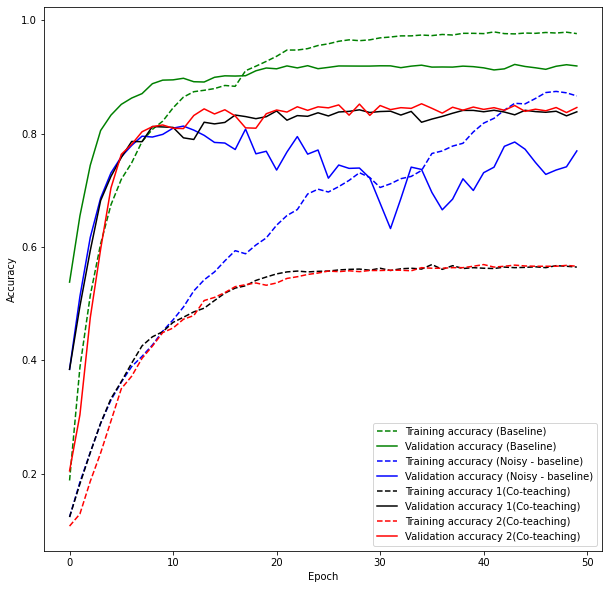

In [26]:
plt.figure(figsize=(10, 10))
logs = [logs_baseline, logs_nb_50_sym]
names = ['Baseline', 'Noisy - baseline']
colors = 'gb'
for i in range(len(logs)):
    plt.plot(range(num_epochs), logs[i]['train_acc'], linestyle='--', color = colors[i], label = 'Training accuracy ('+names[i]+')')
    plt.plot(range(num_epochs), logs[i]['val_acc'], color = colors[i],label = 'Validation accuracy ('+names[i]+')')
plt.plot(range(num_epochs), logs_co_teach_50_sym['train_acc_1'], linestyle='--', color='k', label = 'Training accuracy 1(Co-teaching)')
plt.plot(range(num_epochs), logs_co_teach_50_sym['val_acc_1'], color='k', label = 'Validation accuracy 1(Co-teaching)')
plt.plot(range(num_epochs), logs_co_teach_50_sym['train_acc_2'], linestyle='--', color='r', label = 'Training accuracy 2(Co-teaching)')
plt.plot(range(num_epochs), logs_co_teach_50_sym['val_acc_2'], color='r', label = 'Validation accuracy 2(Co-teaching)')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

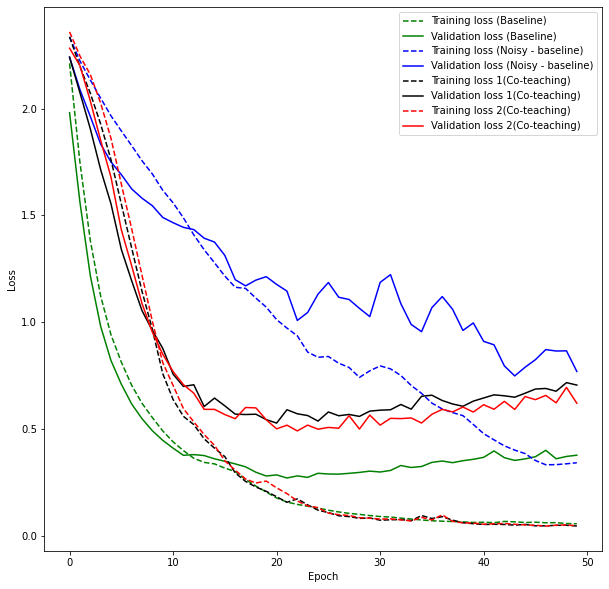

In [27]:
plt.figure(figsize=(10, 10))
for i in range(len(logs)):
    plt.plot(range(num_epochs), logs[i]['train_loss'], linestyle='--', color = colors[i], label = 'Training loss ('+names[i]+')')
    plt.plot(range(num_epochs), logs[i]['val_loss'], color = colors[i],label = 'Validation loss ('+names[i]+')')
plt.plot(range(num_epochs), logs_co_teach_50_sym['train_loss_1'], linestyle='--', color='k', label = 'Training loss 1(Co-teaching)')
plt.plot(range(num_epochs), logs_co_teach_50_sym['val_loss_1'], color='k', label = 'Validation loss 1(Co-teaching)')
plt.plot(range(num_epochs), logs_co_teach_50_sym['train_loss_2'], linestyle='--', color='r', label = 'Training loss 2(Co-teaching)')
plt.plot(range(num_epochs), logs_co_teach_50_sym['val_loss_2'], color='r', label = 'Validation loss 2(Co-teaching)')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')